Materia: Álgebra Lineal Computacional

Trabajo Práctico 1

Equipo: Brasil

Autores: Carolina Julia Cuina, Juana Gala Moran, María Juliana Salfity


In [ ]:
# Carga de paquetes necesarios para graficar
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Para leer archivos
import geopandas as gpd # Para hacer cosas geográficas
import seaborn as sns # Para hacer plots lindos
import networkx as nx # Construcción de la red en NetworkX
import scipy

In [ ]:
import template_funciones
import template_funciones_2
import importlib
importlib.reload(template_funciones)
importlib.reload(template_funciones_2)

<module 'template_funciones_2' from '/content/template_funciones_2.py'>

# Preambulo

En esta sección cargamos los datos y los visualizamos. También construimos la matriz de adyacencia de la red de museos.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Carga de datos de los museos

El listado de los museos, con el que se construye el [mapa](https://mapas.museosabiertos.org/museos/caba/), lo podemos encontrar [acá](https://github.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/blob/principal/data/export.geojson?short_path=bc357f3). También descargamos los barrios de CABA como complemento para los gráficos.

In [ ]:
# Leemos el archivo, retenemos aquellos museos que están en CABA, y descartamos aquellos que no tienen latitud y longitud
museos = gpd.read_file('https://raw.githubusercontent.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/refs/heads/principal/data/export.geojson')
barrios = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson')

## Visualización

<Axes: >

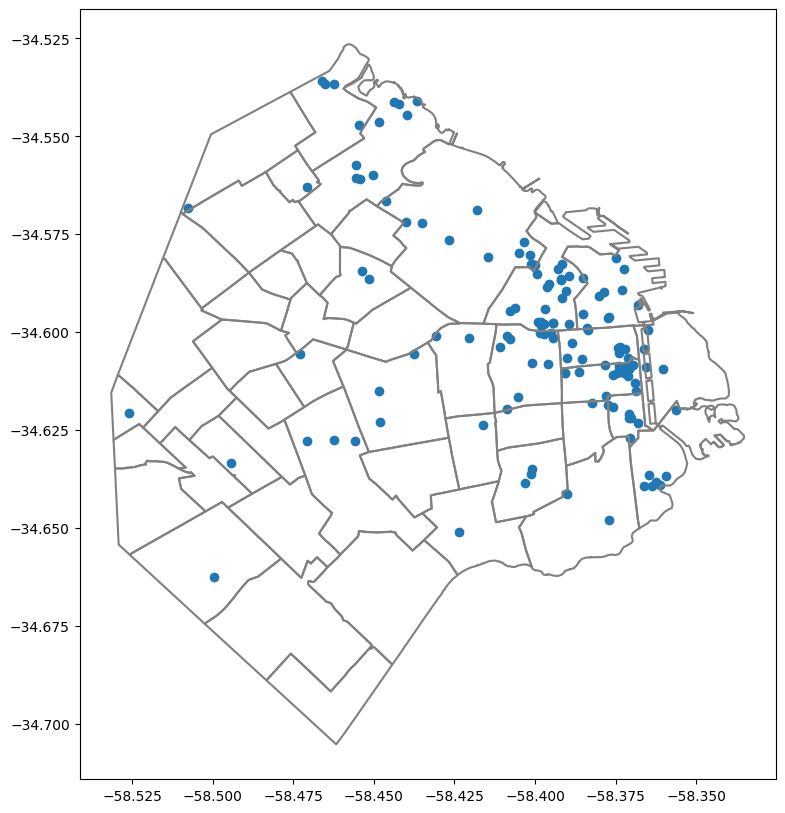

In [ ]:
# Armamos el gráfico para visualizar los museos
fig, ax = plt.subplots(figsize=(10, 10))
barrios.boundary.plot(color='gray',ax=ax)
museos.plot(ax=ax)

## Cálculo de la matriz de distancias

Ahora construimos la matriz de distancias entre todos los museos. Como la tierra es un [geoide](https://es.wikipedia.org/wiki/Geoide) (es decir que no es [plana](https://es.wikipedia.org/wiki/Terraplanismo)), el cálculo de distancias no es una operación obvia. Una opción es proyectar a un [sistema de coordenadas local](https://geopandas.org/en/stable/docs/user_guide/projections.html), de forma tal que las distancias euclideas se correspondan con las distancias en metros. En este notebook usamos [EPSG](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset) 22184.

In [ ]:
# En esta línea:
# Tomamos museos, lo convertimos al sistema de coordenadas de interés, extraemos su geometría (los puntos del mapa),
# calculamos sus distancias a los otros puntos de df, redondeamos (obteniendo distancia en metros), y lo convertimos a un array 2D de numpy
D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy()

### Matriz de adyacencia: construimos una matriz conectando a cada museo con los $m$ más cercanos

In [ ]:
def construye_adyacencia(D,m):
    # Función que construye la matriz de adyacencia del grafo de museos
    # D matriz de distancias, m cantidad de links por nodo
    # Retorna la matriz de adyacencia como un numpy.
    D = D.copy()
    l = [] # Lista para guardar las filas
    for fila in D: # recorriendo las filas, anexamos vectores lógicos
        l.append(fila<=fila[np.argsort(fila)[m]] ) # En realidad, elegimos todos los nodos que estén a una distancia menor o igual a la del m-esimo más cercano
    A = np.asarray(l).astype(int) # Convertimos a entero
    np.fill_diagonal(A,0) # Borramos diagonal para eliminar autolinks
    return(A)

m = 3 # Cantidad de links por nodo
A = construye_adyacencia(D,m)
print (A)


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


## Construcción de la red en NetworkX (sólo para las visualizaciones)

In [ ]:
G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
# Construimos un layout a partir de las coordenadas geográficas
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

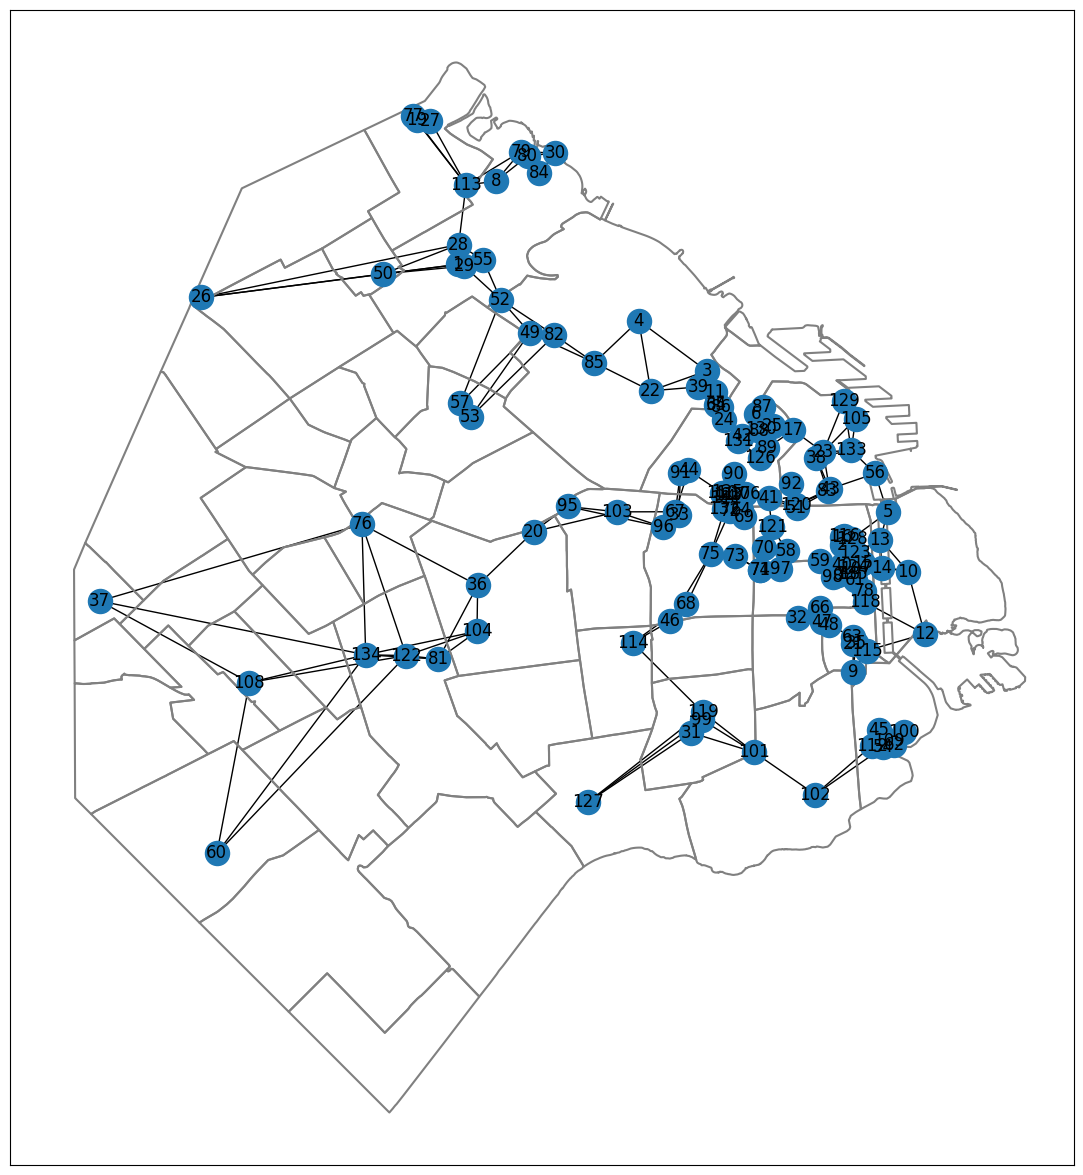

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
nx.draw_networkx(G,G_layout,ax=ax) # Graficamos los museos

# Resolución del TP

Aquí empieza la aventura... ¡diviertanse y consulten lo que necesiten!

Como primer acercamiento al trabajo, experimentamos variando el valor de $m$ en la matriz de adyacencia $A$ y observamos como varia el gráfico. Si bien con un $m$ = 5 los museos periféricos están lo suficientemente conectadas con el resto del mapa, llegamos a la conclusión de que para todo $m \geq 48$ se produce una conexión directa entre todas las zonas de la periferia sin tener que pasar por el centro. Esto implica que, a pesar de estar en un mismo territorio, la distancia afecta fuertemente la relación entre los museos, y aquellos que están muy alejados tienen baja probabilidad de ser visitados en comparación con museos más centrales.

## Punto 1:


Partimos de la ecucación 3, sabiendo que ${\alpha} > 0 \ y\ N > 0 $ :

\begin{align*}
 p = (1 - \alpha) C p + \frac{\alpha}{N} \mathbf{1} \\
p - (1 - \alpha) C p = \frac{\alpha}{N} \mathbf{1} \\
p  f (\mathbf{I} - (1 - \alpha) C) = \frac{\alpha}{N} \mathbf{1} &\rightarrow \text{sacamos factor común p} \\
\frac{N}{\alpha}(\mathbf{I} - (1 - \alpha) C) p = \mathbf{1} \\
\end{align*}

$
\therefore \boxed{\frac{N}{\alpha}(\mathbf{I} - (1 - \alpha) C) p = \mathbf{1} \;\text{para} \; \alpha > 0}
$ \\
\
$
\text{caso} \;{\alpha} = 0 \ y\ N > 0 : \\
\frac{N}{\alpha}(\mathbf{I} - (1 - \alpha) C)  p = \mathbf{1} \\
\frac{N}{\alpha}\; \text{es una indeterminación} \\
\therefore \boxed{\text{para} \ {\alpha = 0} \ \text{no hay solución} }
$

## Punto 2:
Queremos probar que existe una solución única a la ecuación $Mp = b$. En otras palabras, queremos ver que este sistema es compatible determinado. Para ello, $M$ debe ser inversible. Por consiguiente, el determinante de $M$ debe ser distinto de $0$, que es lo mismo que pedir que su rango sea igual a la dimensión de $M$, es decir, $rango(M) = N$.

 Para abordar esto, vamos a analizar primero los casos bordes. Empezamos evaluando qué ocurre cuando $\alpha = 1$ y $\alpha = 0$, para luego extender el análisis al intervalo intermedio. Esto nos va a permitir entender mejor bajo qué condiciones se garantiza la existencia de una única solución.

Caso $\alpha = 1$:
$$ M = \frac{N}{\alpha} \left( I - (1 - \alpha)C \right) $$
$$ M = \frac{N}{1} \left( I - (1 - 1)C \right) $$
$$ M = N(I - 0 * C) $$
$$ \boxed{M = N I} $$

Por otro lado:
$$ \mathbf{p} = (1 - \alpha) C \mathbf{p} + \frac{\alpha}{N} \mathbf{1} $$
$$ \mathbf{p} = (1 - 1) C \mathbf{p} + \frac{1}{N} \mathbf{1} $$
$$ \mathbf{p} = 0 \cdot C \mathbf{p} + \frac{1}{N} \mathbf{1} $$
$$ \boxed{\mathbf{p} = \frac{1}{N} \mathbf{1}} $$


Reemplazando en la ecuación $M\mathbf{p} = \mathbf{b}$:
$$ (N  I) \left( \frac{1}{N} \mathbf{1}\right) = \mathbf{1} $$
$$ I   \mathbf{1} = \mathbf{1} $$
$$ \boxed{\mathbf{1} = \mathbf{1}} $$
$\therefore$ Para $\alpha = 1$, $M\mathbf{p} = \mathbf{b}$. \\
$M$ es la matriz identidad multiplicada por un escalar, entonces es invertible. Por lo tanto, el sistema tiene solución única.

Caso $\alpha = 0$:
$$ M = \frac{N}{\alpha} \left( I - (1 - \alpha)C \right) $$
es una indeterminación por $\frac{N}{0}$. \\
$\therefore$ Para $\alpha = 0$, $M\mathbf{p} = \mathbf{b}$ no tiene solución.

Caso $0 < \alpha < 1$:
Necesitamos que $M$ sea invertible.
$$ M = \frac{N}{\alpha} \left( I - (1 - \alpha)C \right) $$
Definimos la matriz $A$ ya que el producto por el escalar $\frac{N}{\alpha}$ no afecta la invertibilidad de $M$\
$$ A = \left( I - (1 - \alpha)C \right) $$
Si $Det(A) \neq 0$ se cumple que $M$ es invertible.
Sabemos que la diagonal de $C$ está compuesta por todos $0$, ya que se construye a partir de la matriz de adyacencia. Entonces, en la diagonal de $(1 - \alpha)C$ también ocurre lo mismo. Por lo tanto $A= \left( I - (1 - \alpha)C \right) $ va a tener todos $1$ en su diagonal. El producto de los números de la diagonal de $A$ es distinto de $0$ aunque esto no basta para decir que el $Det(A)$ es distinto de $0$ porque carecemos de información acerca de los números bajo la diagonal (no sabemos si $A$ está escalonada). \\
Buscamos demostrar por otro lado, usando el rango de la matriz $M$. \\
Por el enunciado la dimension de $M$ es $N$.
Para que el sistema tenga solución única necesitamos que el $rango(M) = N$. \\
Sabemos que $rango(M) = dim(Im(M))$ \\
Por el teorema de la dimensión vale: $dim(M) = dim(Im(M)) + dim(Nu(M))$.

Por lo tanto:
$$
\begin{array}{l}
dim(M) = rango(M) + dim(Nu(M)) \\
N = N + dim(Nu(M)) \\
\boxed{dim(Nu(M)) = 0}
\\
\end{array}
$$

$M$ es INVERTIBLE $\iff Nu(M) = \{0\}$. \\
$\therefore$ Para que el sistema $M\mathbf{p} = \mathbf{b} \;con\; 0 < \alpha < 1$, tenga solución única la condicion es que el  $Nu(M) = \{0\}
\\ $.

Para demostrar que $M$ es invertible cuando $0 < \alpha < 1$, observamos que:


$M = \frac{N}{\alpha}(I - (1 - \alpha)C) = \frac{N}{\alpha}$ A, donde definimos $A = I - (1 - \alpha)C$. Como el escalar $\frac{N}{\alpha}$ no afecta la invertibilidad, basta con probar que $A$ es invertible.

Sea $B = (1 - \alpha)C$. Como $C$ es una matriz estocástica por columnas (todas las columnas suman 1), se cumple que $\|C\|_1 = 1$. Entonces:

$
\|B\|_1 = (1 - \alpha) \|C\|_1 = (1 - \alpha) < 1.$

Si  $\|B\|_1 < 1$, entonces la matriz $I - B = I - (1 - \alpha)C$ es invertible.

Por lo tanto, $A$ es invertible, y como $M = \frac{N}{\alpha} A$, concluimos que $M$ también es invertible para todo $0 < \alpha < 1$.

$\therefore$ El sistema $Mp = b$ tiene una única solución para $0 < \alpha < 1$.

#Punto 3:
###3a).1 Caso m y $\alpha$ fijos:

Calcularemos el PageRank con $m=3$ (los 3 vecinos más cercanos) y un factor de amortiguación $\alpha = \tfrac{1}{5}$. El vector de PageRank se obtiene resolviendo el sistema:

$ M \, p = b $

donde $M$ es la matriz de transición y $b$ es un vector de unos. Luego, visualizaremos la importancia de cada nodo (museo) de acuerdo con su valor en $p$.

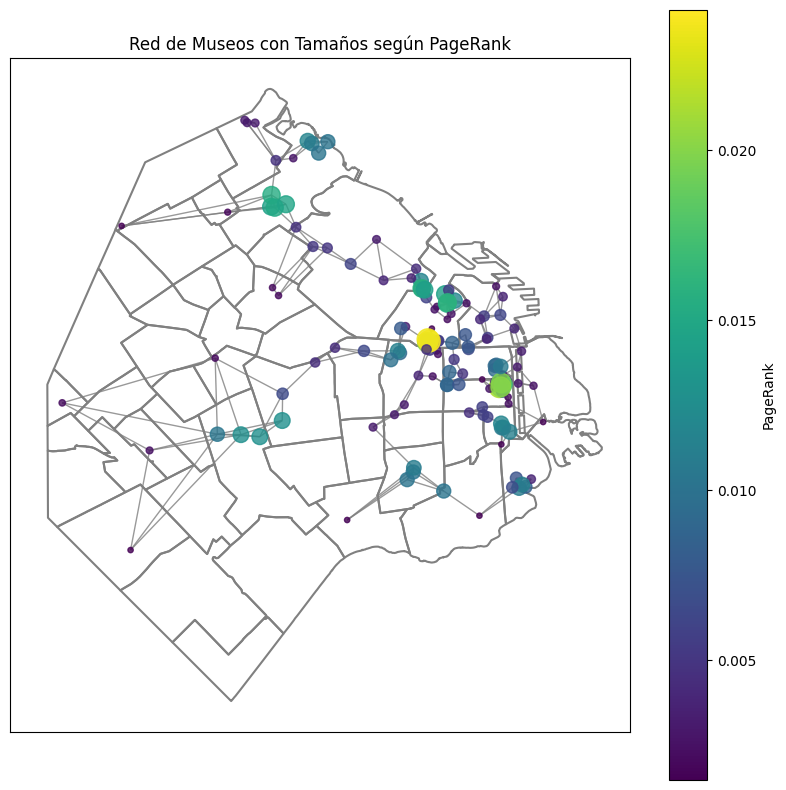

In [ ]:
template_funciones.ejercicio_3_a(D)

+ La zona con más concentración de nodos grandes está en el noreste del mapa, esto sugiere que en esa región se encuentra el núcleo más importante de la red de museos

+ En los extremos del mapa (especialmente al sur y oeste), los nodos son pequeños y oscuros, indicando que esos museos tienen bajo pageRank y podrían estar más aislados o con menos visitas.

+ La red posee una distribución mayormente uniforme en todo el territorio, pero vemos claros puntos centrales que destacan en distintas zonas (nodos más claros y grandes).

+ Las zonas donde se pueden ver los museos con mejor PageRank son Recoleta donde se encuentran entre otros, el museo de Farmacobotanica, Montserrat, donde se ubica el Museo de la Ciudad y Belgrano.

### 3b).1 Variación de $m$

Repetiremos el cálculo para diferentes valores de $m$ : rango_m = \{1, 3, 5, 10\}  
Mantendremos constante el valor de $\alpha = \tfrac{1}{5}$ y observaremos cómo cambia la estructura de la red y la distribución de importancia de los nodos a medida que varía el número de vecinos considerados.

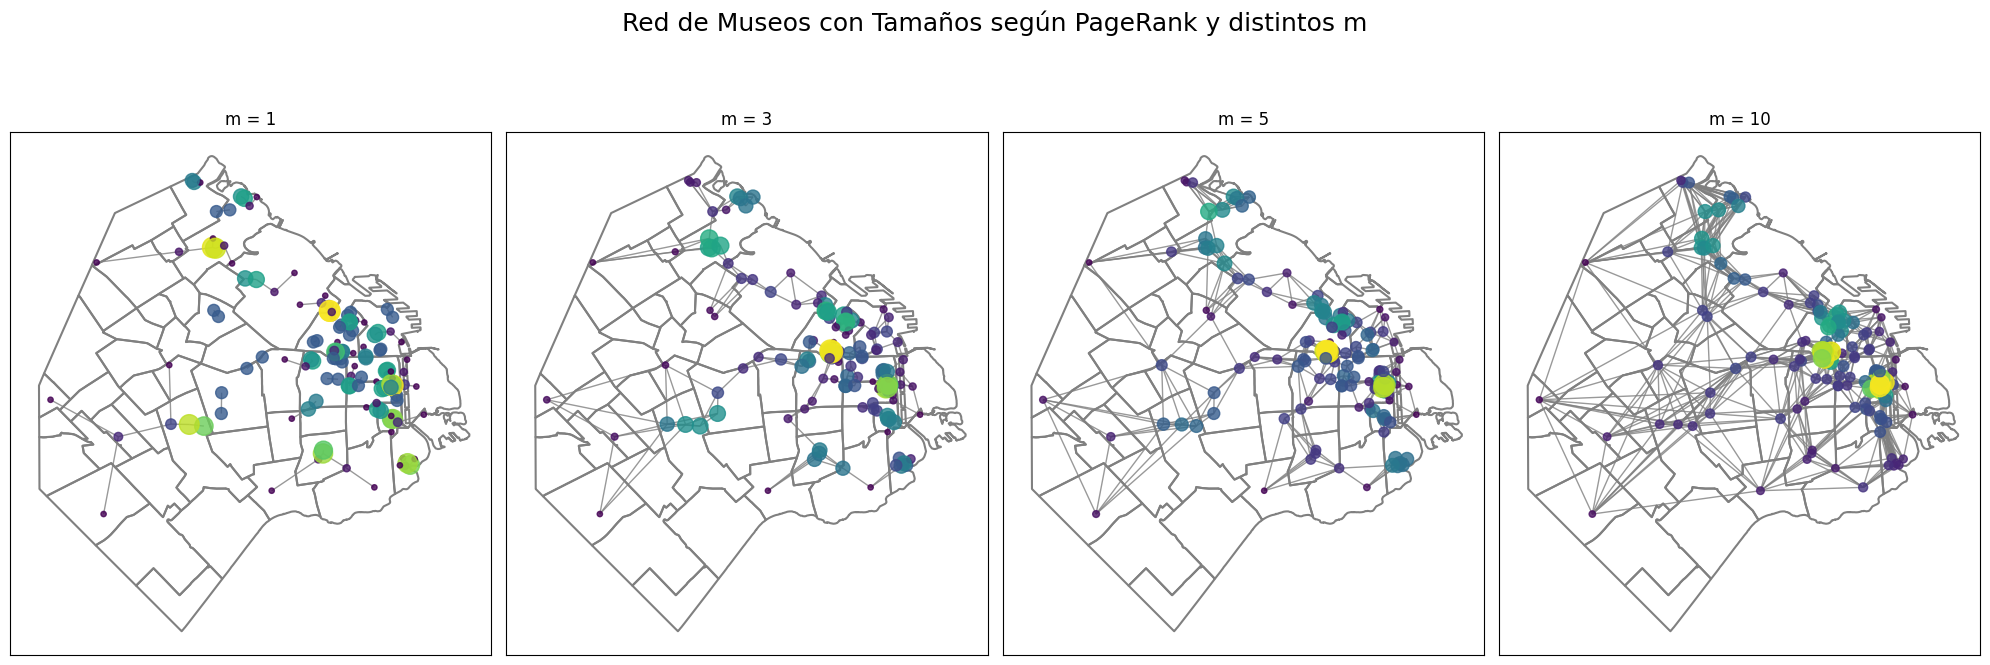

In [ ]:
alpha = 1/5
rango_m = [1,3,5,10]
template_funciones.ejercicio_3_b(D, alpha, rango_m)

### 3c).1 Variación de $\alpha$

Con $m=5$ fijo, analizaremos el impacto de diferentes factores de amortiguación:  
$\alpha = \left\{ \tfrac{6}{7}, \tfrac{4}{5}, \tfrac{2}{3}, \tfrac{1}{2}, \tfrac{1}{3}, \tfrac{1}{5}, \tfrac{1}{7} \right\}$.

Veremos cómo el valor de $\alpha$ afecta la convergencia del algoritmo y la distribución final del ranking de los nodos.

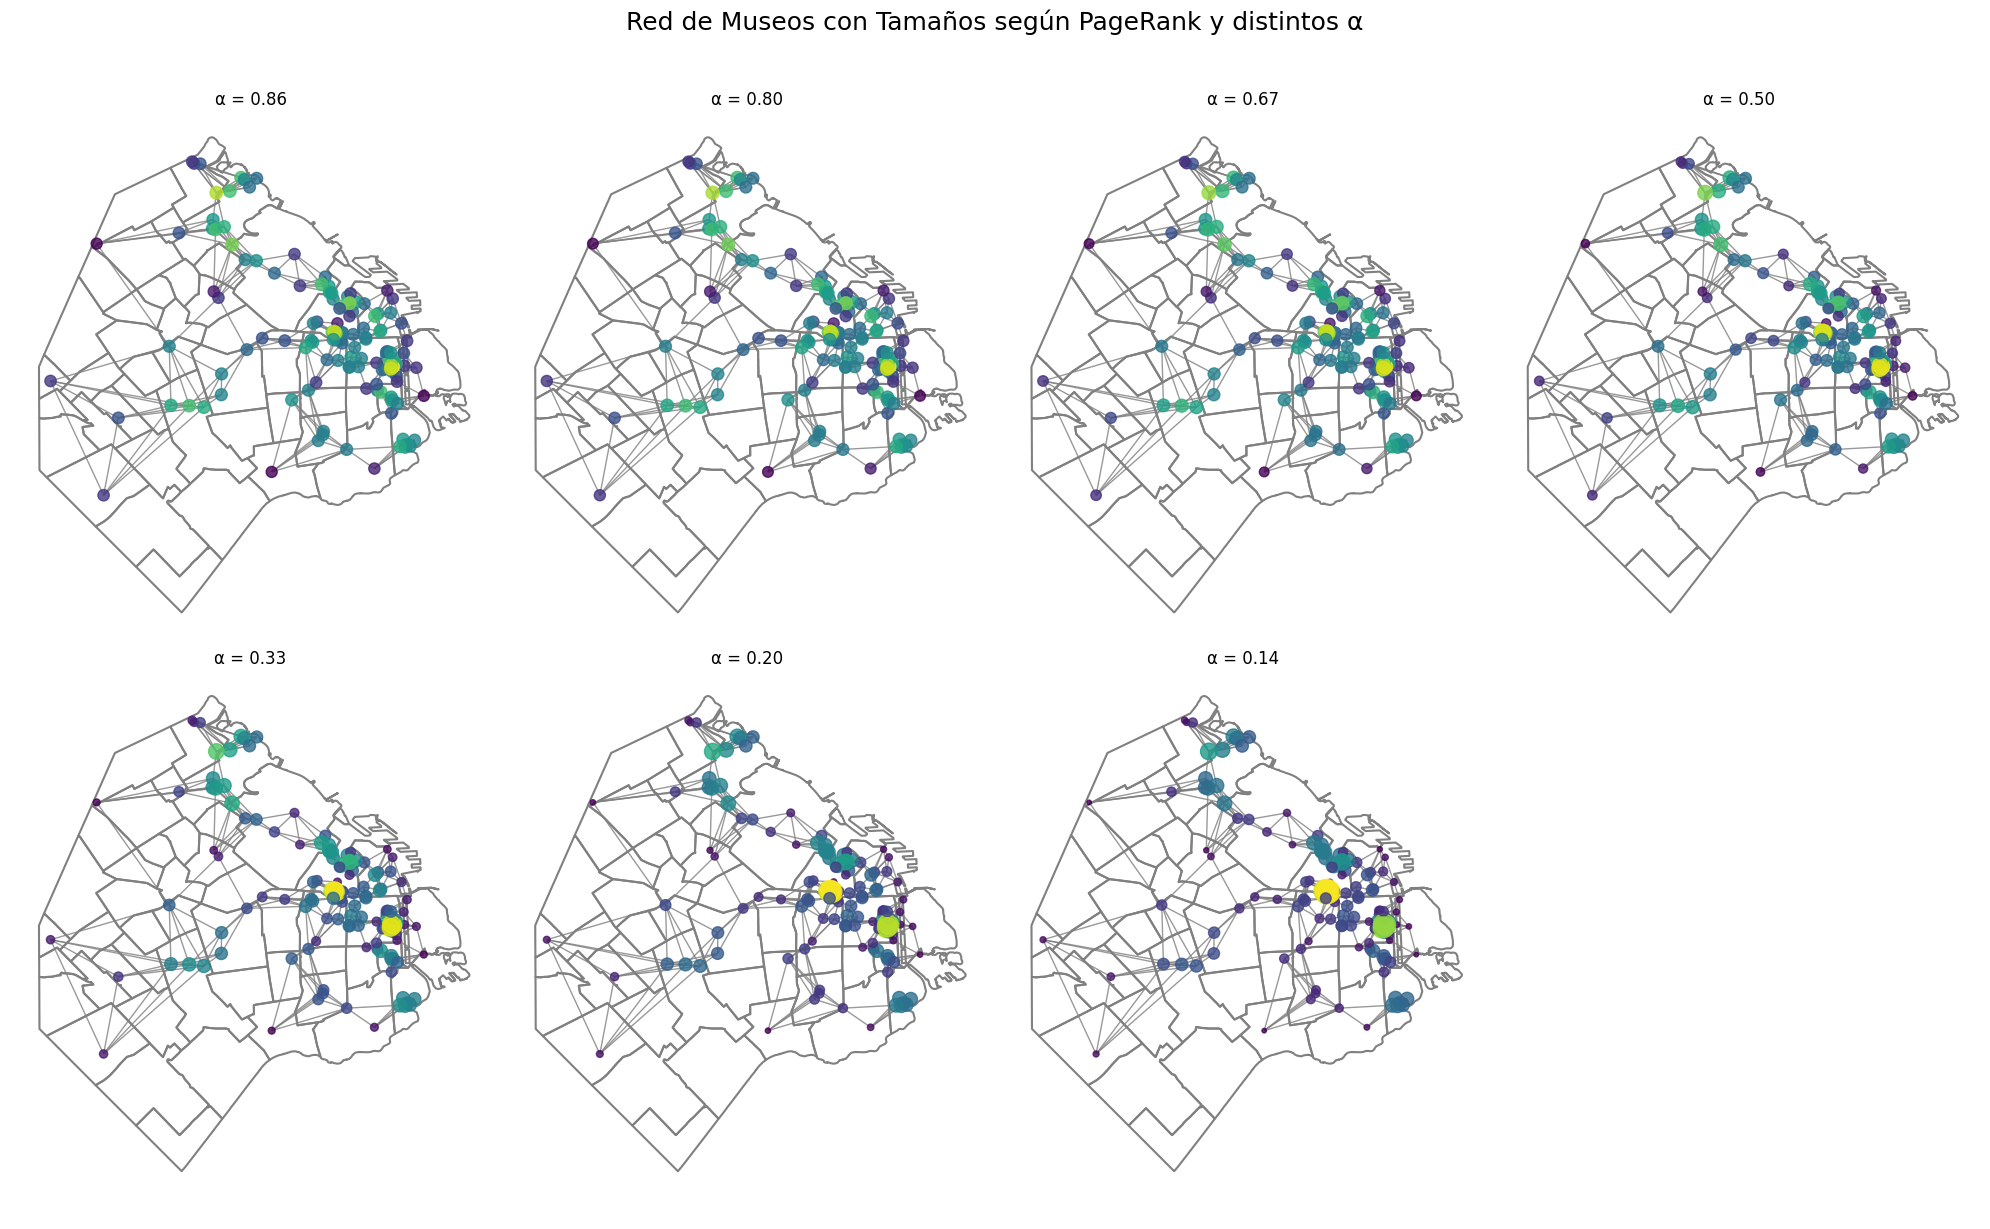

In [ ]:
m = 5
rango_alpha = [6/7,4/5,2/3,1/2,1/3,1/5,1/7]
template_funciones.ejercicio_3_c(D, m,rango_alpha)

### 3a).2 Análisis del ranking

Usando los valores de $p$ obtenidos para cada caso, identificaremos los 3 museos más centrales (variando $m$ o $\alpha$) y graficaremos sus puntajes de Page Rank en función del parámetro que varía.

Analizaremos si las posiciones en el ranking son estables, y describiremos patrones relevantes.

Primero dejamos $\alpha = 1/5$ fijo y variamos $m$ obteniendo el siguiente grafico.

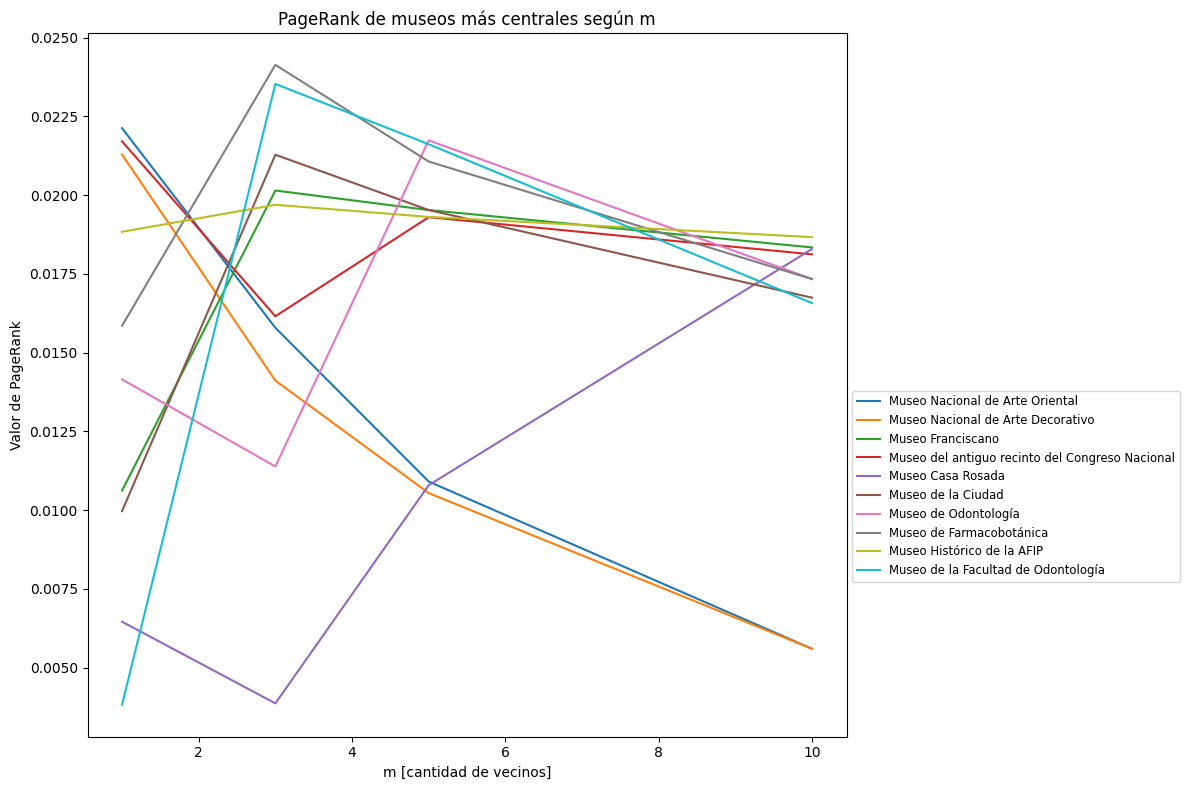

In [ ]:
template_funciones.grafico_mayores_pg_variando_m(D, alpha, rango_m)

Con los valores de PageRank obtenidos para distintos $m$, dejamos fijo $\alpha$ = 1/5 y analizamos cómo varían los puntajes al cambiar la cantidad de vecinos considerados en la red. En el gráfico se muestran los valores para los museos que resultaron más centrales en al menos un caso.

Al observar los resultados, se ven comportamientos distintos según el museo. Por ejemplo, el Museo Nacional de Arte Oriental arranca con un valor alto para $m$ = 1, pero cae bastante a medida que aumenta $m$.

Esto sugiere que su relevancia es más fuerte en redes locales y se diluye cuando se considera un contexto más amplio. Puede ser que esté bien conectado a pocos nodos importantes, pero que su influencia se pierda en redes más grandes.

En cambio, museos como el Museo Histórico de la AFIP o el Museo de Farmacobotánica mantienen valores bastante altos y estables a lo largo de los distintos $m$. Esto indicaría que su centralidad no depende tanto del tamaño de la vecindad: ya son importantes por las conexiones que tienen, independientemente de cuán grande sea la red. Es probable que estén vinculados a otros nodos centrales.

Un caso interesante es el del Museo Casa Rosada, que empieza con un valor bajo y crece a medida que se amplía la red. Esto podría significar que está conectado a nodos importantes que no aparecen en las redes más chicas, y que su influencia se empieza a notar recién cuando se considera un entorno más amplio.

Por otro lado, hay museos como el Museo del Congreso Nacional o el Museo de la Ciudad que muestran bastante variabilidad. Sus valores de PageRank suben y bajan según el $m$, lo que puede indicar que su posición en la red es más inestable. Una posible explicación es que están conectados a nodos que no son consistentes en su importancia, o que su relevancia depende mucho de situaciones puntuales. Valdría la pena mirar bien su vecindad para entender qué tipo de conexiones tienen.



Para terminar el analisis dejamos  $m$ = 5  fijo y variamos $\alpha$:

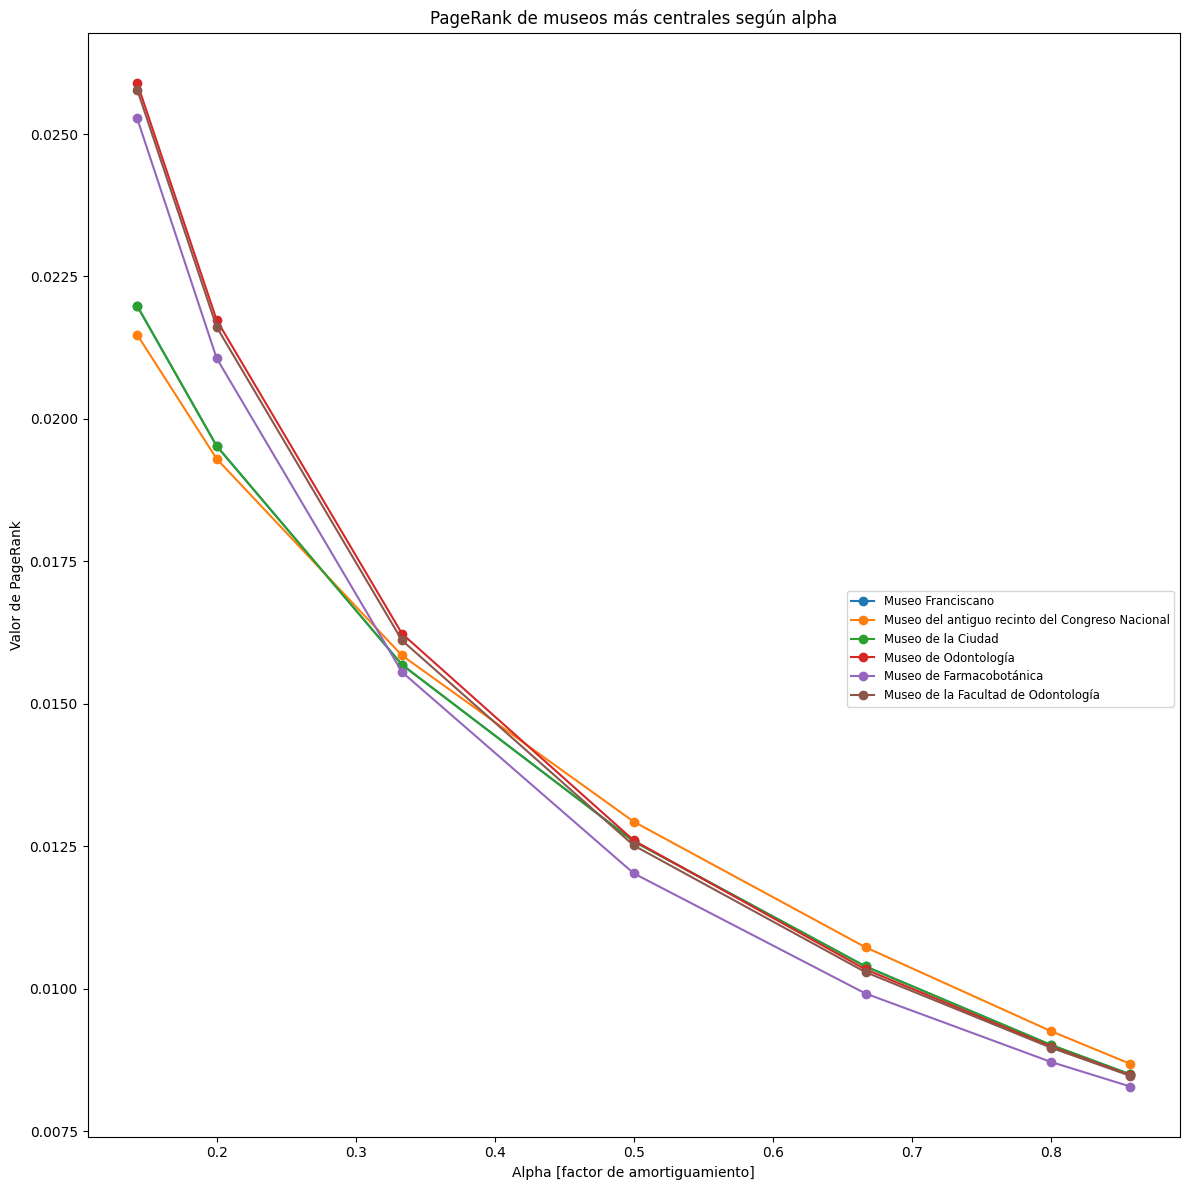

In [ ]:
template_funciones.grafico_mayores_pg_variando_alpha(D, m,rango_alpha)

Analizando la trayectoria de los museos centrales según el rango de $\alpha$= 6/7, 4/5, 2/3, 1/2, 1/3, 1/5, 1/7 y $m$=3.
A grandes rasgos se puede ver que para todos los museos a medida que el valor de $\alpha$ incrementa (aumenta la aleatoreidad) los valores de PageRank tienden a igualarse.
Además se puede observar que cuando $\alpha$ esta entre  1/7 y 1/3 hay mucha dispersión entre los PageRanks de los museos y a medida que $\alpha$ se acerca a 1 esta diferencia se achica.

Con un $\alpha$ bajo, algunos museos capturan mucho valor por su ubicación y los mas alejados quedan con muy poco puntaje.
Con un $\alpha$ alto la dispersión es menor y se favorecen los museos bien enlazados.

El PageRank se distribuye de forma más equitativa cuando los museos están bien conectados entre sí. Por ejemplo, si comparamos este gráfico con otro generado utilizando el mismo rango de valores para $\alpha$, pero con un valor de m=3, observamos que la dispersión de los valores de PageRank entre los museos es mucho mayor. Esto se debe a que, en ese caso, los nodos no están suficientemente enlazados, lo que genera una red menos cohesionada y con mayor desigualdad en la distribución de la centralidad.

Cabe destacar que los museos que mas veces fueron centrales para distintos $\alpha$ son el Museo de Odontologia,el Museo de la Facultad de Odontología y el Museo del antiguo recinto del Congreso Nacional.
Además los museos que obtuvieron un PageRank más alto fueron el Museo de Odontologia,el Museo de la Facultad de Odontología y el Museo de Farmacobotanica.

Una posible explicación de esto es que estos museos se encuentran en posiciones clave dentro de la red: tienen buena conectividad, están cerca de otros nodos relevantes, o bien actúan como "puentes" entre los distintos museos. Esto les permite recibir más visitas dentro del modelo de PageRank, especialmente en escenarios con mayor aleatoriedad.

### 3b).2 Analizamos los graficos de los incisos 3b).1 y 3c).1
Al aumentar el valor de $\alpha$ (menor aletoreidad) el PageRank tiende a distribuirse de manera más equitativa entre los nodos. Esto se debe a que el modelo depende más de la conectividad entre museos. Como resultado, los museos bien conectados (principalmente en la zona noreste de la ciudad) concentran mayor importancia relativa. En cambio, con valores de $\alpha$ bajos (mayor aleatoriedad), la estructura de la red pierde peso. Esto genera una mayor dispersión en los valores de PageRank: algunos museos muy conectados capturan mucho valor, mientras que otros (especialmente los periféricos) quedan con puntajes bajos.


En cuanto a la variación de $m$, vemos un fenómeno opuesto. Con valores bajos de $m$ (como $m=1$), la red es muy dispersa y no conexa: está compuesta por múltiples subredes independientes. En este escenario, cada subred tiene su propio "centro", lo cual genera una red fragmentada, sin un nodo dominante global.

 A medida que aumentamos el $m$, la red se vuelve mas densa. Y se nota un centro geográfico más activo en el noreste de la red. Esto ocurre porque esos nodos acumulan muchas conexiones y pasan a ser claves para el flujo de accesibilidad dentro de la red. Las regiones más conectadas del noreste se consolidan como predominantes (más grandes y amarillas), ya que reciben muchas conexiones y tienen más influencia dentro del grafo.

Se puede ver que para todo $\alpha$ los barrios que contienen a los museos con PageRank mas altos son Montserrat, Recoleta y Balvanera. Lo mismo ocurre para todo $m$ expecto cuando $m$ = 1 que barrios como La Boca, Parque Patricios, Flores y Belgrano cobran relevancia.



## Punto 4:
Suponiendo que cada persona realiza un número fijo de visitas
r antes de abandonar la red, considerando que el recorrido de los visitantes se describe mediante la matriz de transición
C y que la matriz B es inversible es posible establecer una relación entre el vector de entradas v y el vector de visitas totales w.

\begin{align*}
v_0 &= C^0 \ast v_0  \rightarrow \text{entrada a la red} \\
v_1 &= C^1 \ast v_0  \rightarrow \text{distribución de museos luego de 1 paso} \\
\vdots \\
v_{r-1} &= C^{r-1} \ast v_0 \rightarrow \text{distribución de museos luego de r-1 } \text{ pasos} \\
\\
w &= v_0 + v_1 + \cdots + v_{r-1} \\
w &= C^0 \ast v_0 + C^1 \ast v_0 + \cdots + C^{r-1} \ast v_0 \\
w &= \left(\sum_{i=0}^{r-1} C^k\right) \ast v_0 \\
w &= B \ast v_0  \rightarrow  \text{de aca despejamos } v_0 \\ \therefore \boxed{v_0 = B^-1 \ast w}
\end{align*}

Demostramos que el vector de entradas $v$ puede estimarse como $v = B^{-1}w$, siendo $B = \sum_{k=0}^{r-1} C^k$. Esta relación permite reconstruir el origen de las visitas a partir del total observado, considerando el número fijo de pasos $r$ que cada visitante realiza en la red.


## Punto 5:

In [ ]:
cant_pasos = 3
C = template_funciones.calcula_matriz_C_continua(D)
B = template_funciones.calcula_B(C, cant_pasos)
v = template_funciones.resolucion_eq_5(B)
print(f'Cantidad  total de visitantes= {v}')

Cantidad  total de visitantes= 136604.99999999994


Obtenemos el valor de $||v||_1$  que representa la cantidad total de visitantes que entraron en la red, a partir del vector $w$ provisto. \\
La cantidad total estimada de visitantes es aproximadamente $123200.116$. Suponemos que el número obtenido no es entero debido a pequeños errores numéricos en su cálculo, aunque al representar una cantidad de personas debería no poseer decimales. Por lo tanto, aplicamos redondeo y concluimos que la cantidad total de visitantes es $123200$,  con un margen de error numérico aceptable.

#Punto 6

In [ ]:
template_funciones.condicion_1(B)

np.float64(11.293708968770808)

La matriz B  está relativamente bien condicionada. Obtuvimos un número de condición $ \text{cond}_1(B) \approx 11.29 $. Esto significa que alteraciones en el vector $w$ (que representa las visitas registradas por museo) no generan errores muy significativos en el cálculo del vector $v$(las visitas iniciales), el cual se determina mediante:

\begin{align*}
v = B^{-1} w
\end{align*}

A continuación, analizamos la cota para el error relativo en la estimación de $v$, utilizando la desigualdad planteada en el enunciado:

\begin{align*}
\frac{\|v - \hat{v}\|}{\|v\|} \leq \text{cond}_1(B) \cdot \frac{\|w - \hat{w}\|}{\|w\|}
\end{align*}

Asumimos un error relativo del 5\% en los datos del vector $w$:

\begin{align*}
\frac{\|w - \hat{w}\|}{\|w\|} = 0.05
\end{align*}

Reemplazando en la fórmula, obtenemos:

\begin{align*}
\frac{\|v - \hat{v}\|}{\|v\|} \leq 11.29 \cdot 0.05 \approx 0.5645
\end{align*}

Este resultado indica que un error del 5\% en los datos de entrada podría generar un error relativo de hasta un 56.45\% en la solución. Aunque este valor no es despreciable, sigue siendo razonable considerando que estamos resolviendo un sistema con datos reales, donde cierta incertidumbre es esperable.

Cabe destacar que $B$ se construye como una suma de matrices de transición de múltiples pasos:

\begin{align*}
B = I + G + G^2 + \cdots + G^{r-1}
\end{align*}

Este tipo de acumulación puede amplificar ciertos errores si la matriz estuviese mal condicionada.



# Extras

Para graficar la red con un conjunto de puntajes (como el Page Rank)

{0: Text(4924405.086723215, 6160838.106023658, ''),
 1: Text(4917216.80489522, 6166701.553530234, ''),
 2: Text(4924486.298584606, 6161409.256658559, ''),
 3: Text(4921922.052887296, 6164690.544542129, ''),
 4: Text(4920636.67547965, 6165640.199444978, ''),
 5: Text(4925338.320928778, 6162016.528710163, ''),
 6: Text(4922856.100832731, 6163868.567721188, ''),
 7: Text(4922641.894255253, 6162355.100129171, ''),
 8: Text(4917938.7521918025, 6168273.372961773, ''),
 9: Text(4924683.52693892, 6158996.617208998, ''),
 10: Text(4925725.9600755945, 6160896.846339954, ''),
 11: Text(4922075.10183836, 6164294.738410278, ''),
 12: Text(4926038.146946977, 6159721.190876993, ''),
 13: Text(4925200.592014585, 6161503.005610317, ''),
 14: Text(4925229.168803978, 6160973.145341254, ''),
 15: Text(4924875.410406244, 6161061.981187101, ''),
 16: Text(4924474.294424794, 6161547.549492302, ''),
 17: Text(4923553.755484842, 6163571.336254905, ''),
 18: Text(4924615.955668659, 6160843.2491330765, ''),
 19:

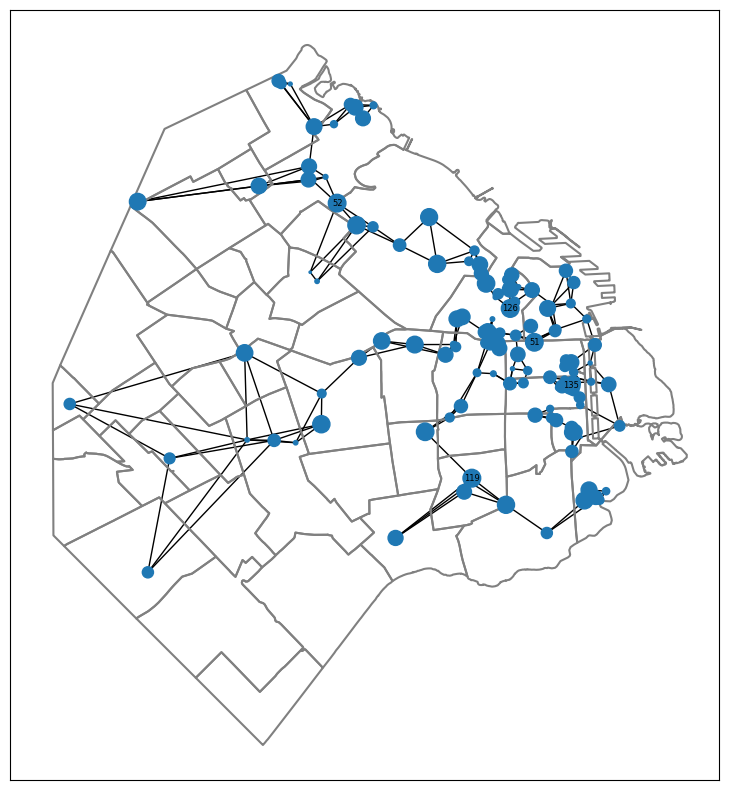

In [ ]:
factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles
fig, ax = plt.subplots(figsize=(10, 10)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
pr = np.random.uniform(0,1,museos.shape[0])# Este va a ser su score Page Rank. Ahora lo reemplazamos con un vector al azar
pr = pr/pr.sum() # Normalizamos para que sume 1
Nprincipales = 5 # Cantidad de principales
principales = np.argsort(pr)[-Nprincipales:] # Identificamos a los N principales
labels = {n: str(n) if i in principales else "" for i, n in enumerate(G.nodes)} # Nombres para esos nodos
nx.draw_networkx(G,G_layout,node_size = pr*factor_escala, ax=ax,with_labels=False) # Graficamos red
nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=6, font_color="k") # Agregamos los nombres

##Punto 1:
#a)
Mostrar que 1 es autovector de L. \\
A simetrica. A matriz de adyacencia.
K diagonal donde $ K_{ii} = \left( \sum_{j=1}^{n} A_{ij} \right)$ \\
Calculamos
$K\overrightarrow{1}$: \\
$
(K\overrightarrow{1})_i = K_{ii} \cdot 1 = \left( \sum_{j=1}^{n} A_{ij} \right)
$
$\Rightarrow K\overrightarrow{1} =
\begin{pmatrix}
\left( \sum_{j=1}^{n} A_{1j} \right) \\
\left( \sum_{j=1}^{n} A_{2j} \right) \\
\vdots \\
\left( \sum_{j=1}^{n} A_{nj} \right)
\end{pmatrix}
$ \\
Calculamos $A\overrightarrow{1}$: \\
$
(A\overrightarrow{1})_i = \left( \sum_{j=1}^{n} A_{ij} \right)
$
$\Rightarrow A\overrightarrow{1} =
\begin{pmatrix}
\left( \sum_{j=1}^{n} A_{1j} \right) \\
\left( \sum_{j=1}^{n} A_{2j} \right) \\
\vdots \\
\left( \sum_{j=1}^{n} A_{nj} \right)
\end{pmatrix}
$ \\
$
L = K - A \\
\text{Luego} \\
L\overrightarrow{1} = (K - A)\overrightarrow{1} \\
L\overrightarrow{1} = K\overrightarrow{1} - A\overrightarrow{1} \\
L\overrightarrow{1} = \begin{pmatrix}
\left( \sum_{j=1}^{n} A_{1j} \right) \\
\left( \sum_{j=1}^{n} A_{2j} \right) \\
\vdots \\
\left( \sum_{j=1}^{n} A_{nj} \right)
\end{pmatrix} - \begin{pmatrix}
\left( \sum_{j=1}^{n} A_{1j} \right) \\
\left( \sum_{j=1}^{n} A_{2j} \right) \\
\vdots \\
\left( \sum_{j=1}^{n} A_{nj} \right)
\end{pmatrix}  = 0 \\
L\overrightarrow{1} = 0 \\
\therefore \overrightarrow{1}
\text{es autovector asociado al autovalor}\;\lambda = 0
$

Mostrar que 1 es autovector de R. \\
$
R = A - P \\
P_{ij} = \frac{k_ik_j}{2E}\;\text{donde }k_i = \left( \sum_{j=1}^{n} A_{ij} \right) \\
2E = \left( \sum_{j=1}^{n} K_i \right) \\
Entonces \\
(P\overrightarrow{1})_i = \sum_{j=1}^{n} \frac{k_ik_j}{2E} = \frac{k_i}{2E}\sum_{j=1}^{n} k_j = \frac{k_i}{2E}2E = K_i \\
\Rightarrow P\overrightarrow{1} =
\begin{pmatrix}
k_1 \\
k_2 \\
\vdots \\
k_3
\end{pmatrix} = A\overrightarrow{1} \\
\text{Por otro lado, } \\
R = A - P \\
\text{Luego } \\
R\overrightarrow{1} = (A - P)\overrightarrow{1} = (A\overrightarrow{1} - P\overrightarrow{1}) = (\overrightarrow{K} - \overrightarrow{K}) = 0
$
$\text{Tanto para L como para R el autovector 1 representa que todos los nodos pertenecen al mismo grupo. Es decir no se ha realizado ninguna segmentación sino que se considera a toda la red como una única comunidad.}$

#b) Mostrar que si L(R) tienen 2 autovectores $v_1, v_2$ asociados a $\lambda_1 \ne \lambda_2 ⇒ v_1^t v_2 = 0
$
Vamos a demostrarlo para L aunque para R la demostracion es identica porque L y R son matrices simetricas.
$ \text{Hipótesis: }
Mv_2 = \lambda_2v_2 \text{ y } Mv_1 = \lambda_1v_1\\
Mv_2 = \lambda_2v_2 \\
v_1^tMv_2 = v_1^t\lambda_2v_2 \text{ multiplico por }v_2^t \\
(Mv_1)^tv_2 = \lambda_2v_1^tv_2 \\
(\lambda_1v_1)^tv_2 = \lambda_2v_1^tv_2 \\
\lambda_1v_1^tv_2 = \lambda_2v_1^tv_2 \\
\lambda_1v_1^tv_2 - \lambda_2v_1^tv_2 = 0 \\
(\lambda_1 - \lambda_2)(v_1^tv_2) = 0 \\
\Rightarrow \boxed{v_1^tv_2 = 0}
$
\\
$
\text{Partiendo de la misma hipótesis: } Mv_2 = \lambda_2v_2 \text{ y } Mv_1 = \lambda_1v_1\\
Mv_1 = \lambda_1v_1 \\
v_2^tMv_1 = v_2^t\lambda_1v_1 \text{ multiplico por }v_1^t \\
(Mv_2)^tv_1 = \lambda_1v_2^tv_1 \\
(\lambda_2v_2)^tv_1 = \lambda_1v_2^tv_1 \\
\lambda_2v_2^tv_1 = \lambda_1v_2^tv_1 \\
\lambda_2v_2^tv_1 - \lambda_1v_2^tv_1 = 0 \\
(\lambda_2 - \lambda_1)(v_2^tv_1) = 0 \\
\Rightarrow \boxed{v_2^tv_1 = 0}
$

#c) Mostrar que si $v$ es un autovector asocidado de $\lambda \ne 0$ de $R$ o $L$ $\Rightarrow (\sum_{i=1}^{n} v_i) = 0 $
# Demostración para L \\
$
\text{Parto de la hipótesis:} \\
L = K - A \\
L \text{ semi definida positiva} → λ \geq 0 \;\forall\;  λ \\
L \text{ simetrica, } λ_1 \neq λ_2 → v_1 \perp v_2 \\
\\    .\\
\text{Descartamos el caso } L\vec{1} = 0 \text{ pues } λ \neq 0 \\
L \text{ semi definida positiva y } λ  \neq  0 ⇒ λ > 0\;\forall\;λ \\
L \text{ simetrica } ⇒ \text{ sus autovectores forman una bon } \\
⇒ \text{tomo }v \text{ asociado a } λ \neq 0 \;\text{tal que } v \perp v_1 \\
v_1^tv = 0 ⇒ (\sum_{i=1}^{n} v_i) = 0 \\
\therefore \boxed{(\sum_{i=1}^{n} v_i) = 0} \\
\text{por ejemplo en R^3} \\
 (1,1,1)*\begin{pmatrix}
v_1 \\
v_2 \\
v_3
\end{pmatrix}
= v_1 + v_2 + v_3
$

#Demostración para R
$
R = A - P \\
\text{Hipótesis:} \\
R \;simetrica ⇒ \text{admite una bon de sus autovectores.} \\
\vec{1} \text{ es autovector asociado a } λ = 0 \\
\text{tomo } v \text{ asociado a } λ \neq 0 \\
⇒ v_1^tv = 0 \\
\therefore \boxed{(\sum_{i=1}^{n} v_i) = 0,\; λ \neq 0}
$


# Punto 2
# a)
Sabemos que M es diagonalizable con $\lambda_i$ autovalores asociados a $v_i$. Queremos ver que los autovalores de $M + \mu I$ son $\gamma_i = \lambda_i + \mu$ :  
$(M + \mu I)v_i = M v_i + \mu I v_i = \lambda_i v_i + \mu v_i$

* sacando factor común $v_i$:

$(M + \mu I)v_i = (\lambda_i + \mu) v_i$

$ \Rightarrow v_i$ es autovector de $M + \mu I$ con autovalor $\gamma_i = \lambda_i + \mu$

\\


Con $ \lambda_i + \mu \neq 0 $  $\forall i \Rightarrow$ det($M$) $\neq$ 0
 pues det($M$) = $\prod_{i=1}\gamma_{i}$

$\boxed{ \Rightarrow \text{La matriz es inversible.}}$
                  



# b)
En el item a) vimos que con $\mu$ > 0, la matriz $L + \mu I$ es inversible porque los autovalores de $L$ son $\lambda_i > 0$ y por consecuencia los autovalores de $L + \mu I$ son $\lambda_i + \mu > 0 $ pues $\mu > 0 (\forall i) $.

\\

Aplicar el Método de la potencia inverso a una matriz $M$ consiste en aplicar el Método de la potencia a $M^{-1}$.
   
* $Mv = \lambda v  \Rightarrow M^{-1}v = \frac{1}\lambda v  (*)$

\\

Por lo tanto, el autovalor más grande de $M^{-1}$ corresponde al que tiene al autovalor mas chico de $M$ en el denominador.

Entonces, aplicar el MDP a la matriz ($L + \mu I)^{-1}$ nos va a permitir encontrar el autovector que esta asociado al autovalor más chico ($\gamma_{min}$) de la matriz $L + \mu I$.
* $L$ es semidefinida positiva $\Rightarrow \lambda_i \geq 0$  $\forall$ $i$, ademas $\mu > 0$

 $\lambda_{min}(L) = 0$ es el autovalor mas chico de L (demostrado en 1a.) con $v_{\lambda = 0} = \vec{1}$

 Por otro lado los autovalores de $\tilde{L} = (L + \mu I)$ son $ \gamma_i = \lambda_i(L) + \mu$

  Entonces el $\gamma_{min}(\tilde{L}) =  \lambda_{min}(L) + \mu = 0 + \mu = \mu$  

  Por propiedad ($*$)


 $\Rightarrow \gamma_{max}(\tilde{L}) = \frac{1}{\lambda_{min} + \mu} = \frac{1}{\mu} $.
 Su autovector correspondiente es $\vec{1}$ (el mismo asociado a $\lambda_{\min}(L)$).

 $\boxed{\therefore \text{Entonces, si se parte de una semilla con proyección no nula sobre } \vec{1},  \tilde{L}^{-1} \text{converge a } \vec{1}}$.

 \\

 En el caso en que el autovalor mínimo de $L$ (que es 0) tenga multiplicidad 1, el único autovector asociado es:

$\vec{v} = \begin{pmatrix} 1 \\ 1 \\ \vdots \\ 1 \end{pmatrix}$

  Entonces:
  * El único autovalor de $L + \mu I $ con menor valor es $\gamma_{min} = \mu$
  *  El único autovector asociado (salvo escalares) es $\vec{v}$

   Y como estamos aplicando el método de la potencia inverso a $(L + \mu I)^{-1}$ el autovalor asociado a $\vec{v}$ es $ \boxed{ \gamma = \frac{1}{\mu}}$

# c)
Sea $M$ una matriz simétrica, con autovalores $\lambda_1, \lambda_2, \dots, \lambda_n$ y autovectores ortonormales $v_1, v_2, \dots, v_n$ tales que $M v_i = \lambda_i v_i$.

Definimos la matriz:

$\tilde{M} = M - \lambda_1 \frac{v_1 v_1^t}{v_1^t v_1}$

Como $v_1^t v_1$ es escalar (la norma al cuadrado), vale:
$\tilde{M} v_1 = M v_1 - \lambda_1 \frac{v_1 v_1^t}{v_1^t v_1} v_1 = \lambda_1 v_1 - \lambda_1 v_1 = 0$

Entonces, $v_1$ sigue siendo autovector, pero con autovalor asociado 0.

Ahora, si $v_i$ es un autovector ortogonal a $v_1$ (es decir, $v_1^t v_i = 0$), se tiene:

$\tilde{M} v_i = M v_i - \lambda_1 \frac{v_1 v_1^t}{v_1^t v_1} v_i = \lambda_i v_i - \lambda_1 \cdot 0 = \lambda_i v_i$

Por lo tanto, los demás autovectores se conservan con sus respectivos autovalores.

$\boxed{\therefore \tilde{M} \text{ tiene los mismos autovectores que } M\text{, pero el autovalor asociado a }v_1 \text{ ahora es 0.}}$






#Punto 3

Aplicamos la funciones 'laplaciano iterativo(A,niveles)' y 'modularidad iterativo(A)' a la matriz asociada al grafo de la Figura 1.

3)a. Funciones que encuentren los autovectores a través del método de la
potencia:

In [ ]:
L = template_funciones_2.calcula_L(template_funciones_2.A_ejemplo)
mu = 1e-5
autovect2_L, autoval2_L, _ = template_funciones_2.metpotI2(L,mu)

R = template_funciones_2.calcula_R(template_funciones_2.A_ejemplo)
autovect_max_R, autoval_max_R, _ = template_funciones_2.metpot1(R)

s_L = template_funciones_2.calcula_s(autovect2_L)
s_R = template_funciones_2.calcula_s(autovect_max_R)

print("Autovector asociado al segundo autovalor más chico de L:", autoval2_L)
print("Autovector asociado al autovalor más grande de R:", autovect_max_R)
print("Vector s asociado a L:", s_L)
print("Vector s asociado a R:", s_R)

Autovector asociado al segundo autovalor más chico de L: 0.7639320234517567
Autovector asociado al autovalor más grande de R: [-0.39410272 -0.39410272 -0.3077488  -0.3076634   0.3076634   0.3077488
  0.39410272  0.39410272]
Vector s asociado a L: [-1. -1. -1. -1.  1.  1.  1.  1.]
Vector s asociado a R: [-1. -1. -1. -1.  1.  1.  1.  1.]


In [ ]:
print("La partición optima en 4 grupos para el método basado en el laplaciano sería:", template_funciones_2.laplaciano_iterativo(template_funciones_2.A_ejemplo,2))
print("La partición optima basado en el metodo modularidad sería:",template_funciones_2.modularidad_iterativo(template_funciones_2.A_ejemplo))

La partición optima en 4 grupos para el método basado en el laplaciano sería: [[3, 5], [6, 7], [2, 4], [0, 1]]
La partición optima basado en el metodo modularidad sería: [[0, 1, 2, 3], [4, 5, 6, 7]]


La funcion 'laplaciano_iterativo' realiza cortes recursivos usando el segundo autovector del Laplaciano para separar los nodos según el signo del vector, dividiendo así el grafo en 4 grupos, donde cada sublista representa un grupo. La partición obtenida es la solución óptima que ofrece el método espectral con base en el Laplaciano para dividir el grafo en 4 comunidades.

Por otro lado, la funcion 'modularidad iterativo' realiza divisiones iterativas que maximizan la calidad de la partición según la medida de modularidad. Esto se logra evaluando y seleccionando cortes que aumentan la modularidad. En este caso, el metodo no encontró ninguna partición que aumente el valor de modularidad. Por lo tanto, considera todo el grafo como una sola comunidad.

#Punto 4

Usando la red de museos, calculamos las particiones optimas usando el metodo basado en el laplaciano y el metodo basado en la modularidad.
Utilizamos la matriz de adyacencia A construida usando m = [3, 5, 10, 50], luego la simetrizamos.
Exploramos como cambia la estructura de comunidades obtenida usando la modularidad encontrada para distintos valores de m.
Comparamos visualmente las comunidades obtenidas mediante el laplaciano y la
modularidad.

In [ ]:
lista_m = [3,5,10,50]
metodo_laplaciano = 0
template_funciones_2.comunidades_subplot(D,lista_m, metodo_laplaciano)

NameError: name 'template_funciones_2' is not defined

Con m = 3 se detectan 9 comunidades. La red es muy dispersa y la conectividad es baja.
Con m = 5 se detectan 14 comunidades.
Con m = 10 se detectan 15 comunidades.
Con m = 50 se detectan 16 comunidades. La red es muy densa.
Se puede ver que luego de que el m es mayor o igual a 5 las comunidades incrementan cada vez menos. De forma que con m = 5 el grafo ya tiene suficiente conectividad para que el algoritmo capte la mayor parte de las comunidades relevantes.

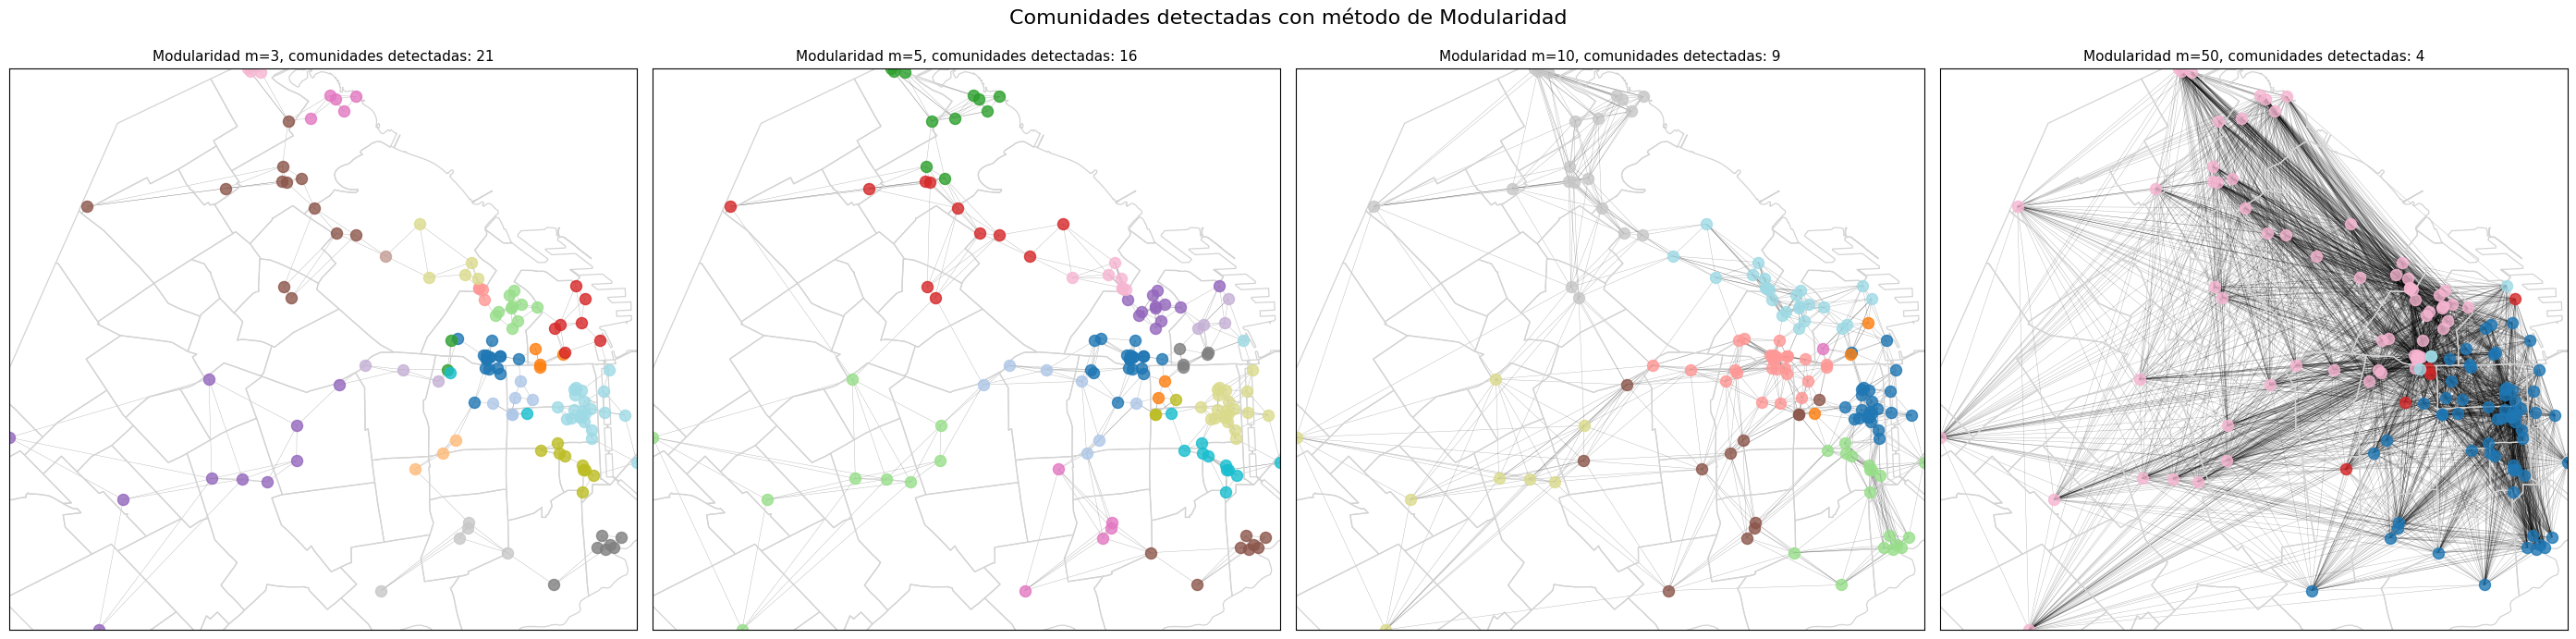

In [ ]:
metodo_modularidad = 1
template_funciones_2.comunidades_subplot(D,lista_m, metodo_modularidad)

Con m = 3 se detectan 21 comunidades. Se puede ver que los grupos estan segmentados por cercania geografica y son muy pequeños. Aunque en la zona derecha superior hay una alta concentración de comunidades aunque sean muy cercanas unas de otras.
Con m = 5 se detectan 16 comunidades. La segmentación de los grupos es muy clara con este valor de m es interesante analizar las comunidades identificadas.
Con m = 10 se detectan 9 comunidades. La red se ve un poco mas densa que con los valores anteriores de m. Algunas comunidades se fusionan. Se ven 3 comunidades influyentes todas ubicadas sobre la parte derecha superior en el grafo.
Con m = 50 se detectan 4 comunidades. La red es muy densa. El grafo es muy difuso. Predominan dos grandes grupos.

Vamos a comparar visualmente Las comunidades detectadas con ambos metodos para m = 5.
Con el método de modularidad los grupos estan bien definidos y compactos. Mientras que las comunidades identificadas por el metodo basado en el laplaciano son dispersas y el tamaño de estas es pequeño.
El metodo de modularidad tal vez agrupa a los museos por cercania y corta la red en regiones “naturales” con pocas conexiones entre ellas. Este algoritmo favorece la formación de comunidades densas internamente y débilmente conectadas entre sí. Esto tiende a reflejar patrones espaciales, como agrupamiento de museos por barrios o zonas de la ciudad.
Mientras el metodo basado en el Laplaciono segmenta los museos con otros patrones. Las comunidades estan más dispersas: Los grupos detectados pueden estar formados por nodos que no están espacialmente juntos, pero sí conectados estructuralmente. El tamaño de las comunidades es pequeño y los museos conectados no estan necesariamente cerca. Este algortimo refleja cómo fluyen las conexiónes a través de la red.


#Punto 5
A lo largo de este trabajo trabajamos con una red de museos de la Ciudad de Buenos Aires. Gran parte del analisis de la red se baso con m = 5 (cantidad de conexiones entre museos) porque cuando construimos el grafo vimos que los museos estan lo suficientemente conectados entre si y los museos perifericos se encuentran lo suficientemente conectados con el resto del mapa.

En primer lugar, analizamos como variaron los Pagerank de los museos variando m, con alpha fijo (factor de amortigución).En segundo lugar estudiamos los puntajes variando alpha, con m = 5. Se puede observar que a medida que aumenta alpha los valores de PageRank tienden a igualarse.
Cuando α es pequeño hay mucha dispersión entre los valores de PageRanks. Algunos museos capturan mucho valor por su ubicación y los mas alejados obtienen muy poco. A medida que alpha aumenta el PageRank se distribuye de forma más equitativa y los nodos bien enlazados son favorecidos.

En sintésis, al aumentar el valor de α el PageRank tiende a distribuirse de manera más equitativa entre los museos,el modelo pasa a depender más de la conectividad entre nodos y los museos bien conectados cobran mayor importancia.
En cambio, con mayor aleatoriedad, la estructura de la red pierde peso. Generando una mayor dispersión en los valores de PageRank.
Con respecto a la variación del parámetro 𝑚, se observa que con valores bajos la red es más dispersa y presenta baja conectividad, lo que da lugar a una distribución desigual. A medida que m aumenta, la red se densifica y se destaca un centro geográfico más activo en el noreste del mapa.

En la segunda parte del trabajo se pusieron a prueba dos métodos iterativos de clustering no supervisados: uno basado en el Laplaciano del grafo y otro en la modularidad. Como criterios de evaluación se utilizaron el corte mínimo y la modularidad, y se trabajó con la matriz de adyacencia
A construida para distintos valores de m, la cual fue posteriormente simetrizada.
Se exploró cómo cambia la estructura de comunidades detectada según el método utilizado y el valor del parámetro m, analizando primero cada método por separado.

Metodo del Laplaciano:
A medida que el m incrementa va detectando cada vez mas comunidades.
Con m  bajo se detectan pocas comunidades, la red es muy dispersa y la conectividad es baja.
Para los m mayores a 5 las comunidades detectadas incrementan cada vez menos y la red es cada vez mas densa. Lo que sugiere que para ese valor de m ya se detectaron todas las comunidades relevantes.

Metodo de modularidad:
A medida que m incrementa disminuye el numero de comunidades.
Con m bajo se detectan muchas comunidades. Se puede ver que los grupos estan segmentados por cercania geografica y son muy pequeños.
Con m = 5 la segmentación de los grupos es muy clara.
Luego la red es cada vez mas densa y algunas comunidades comienzan a fusionanarse hasta que el grafo se vuelve difuso y solo predominan dos grandes grupos.

En segunda instancia decidimos comparar las comunidades detectadas en ambos metodos para m = 5. Con el método de modularidad los grupos estan bien definidos y compactos.  
Este metodo agrupa a los museos por cercania y favorece la formación de comunidades densas internamente y débilmente conectadas entre sí.
Mientras que en el Laplaciono las comunidades estan más dispersas: Los grupos detectados estan formados por nodos que no están espacialmente juntos, pero sí conectados entre si.
El tamaño de las comunidades es pequeño. Este algortimo refleja cómo fluyen las conexiónes a través de la red.